# Lesson 39: Basic image quantification

(c) 2017 Justin Bois and Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l39_segmentation.ipynb).*

In [1]:
import numpy as np

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

Now that we have learned how to do basic segmentation, we continue our image processing lessons to learn how to obtain quantitative data from images.

In this lesson, we will expand on what we learned in the first image processing tutorial and develop some further skills to help us with segmentation of images.  The images we will use were acquired by Griffin Chure in Rob Phillips's lab here at Caltech.  The bacteria are the HG105 *E. coli* strain, developed for [an earlier paper from the Phillips lab](http://www.pnas.org/content/108/29/12173.full).  The strain is wild type, except the LacZYA genes are deleted.  It features a YFP gene hooked up to the Lac promoter.  Thus, the fluorescent signal is a measure of gene expression governed by the Lac promoter in the absence of several of its repressors.

In the [previous lesson](l38_intro_to_image_processing.html), we made strong arguments for performing segmentation on images of bacteria constitutively expressing a fluorescent protein.  The main motivation is that the haloing effect from phase contrast images makes segmenting bacteria in large clumps very difficult.  However, for the images we are analyzing here, we do not have a constitutive fluorescent protein.  It is a bad idea to use the fluorescent signal we are measuring to do the segmentation, since this could introduce bias, especially when we have very low fluorescent signal for some cells.  So, in this experiment, we will do the segmentation using the phase image and then use the fluorescent image to get a measure of the fluorescence intensity for each bacterium.  It is important to have a dilute field of bacteria so that we do not have clumps of bacteria that make segmentation difficult.

Importantly, we are free to manipulate the brightfield image as we like in order to get good segmentation.  After we have identified which pixels below to which cells, we have to be very careful adjusting the fluorescent images as the pixel values in these images are the signal we are measuring.  We will only employ a median filter with a very small structuring element to deal with the known camera issue of occasional rogue high intensity pixels.

## Inspecting the images

Let's start by just getting a look at the images to see what we're dealing with here. A collection of images can be found in `data/HG105_images` which will be used for this lesson and the following practice section. The specific images we will be looking at here will be `noLac_phase_0000.tif` and `noLac_FITC_0000.tif`.  

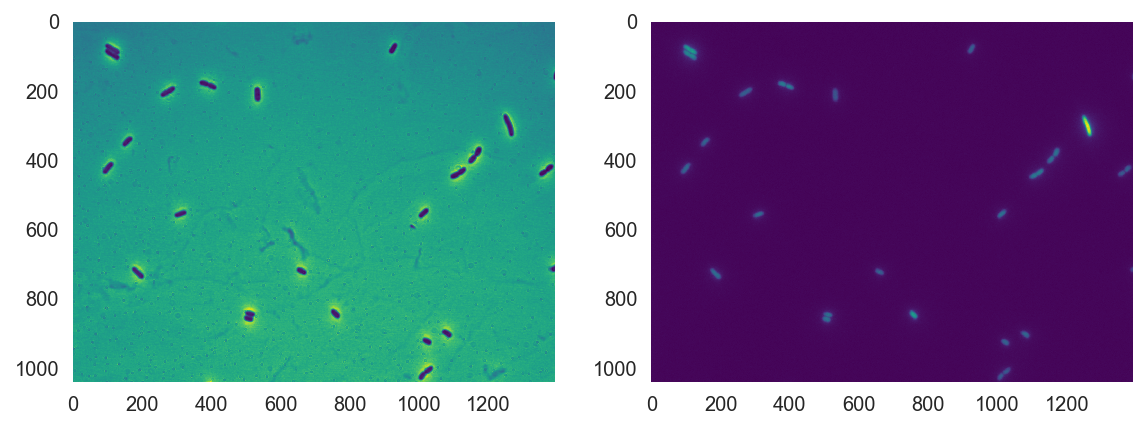

In [2]:
# Load the images
im_phase = skimage.io.imread('data/HG105_images/noLac_phase_0004.tif')
im_fl = skimage.io.imread('data/HG105_images/noLac_FITC_0004.tif')

# Display side-by-side
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase, cmap=plt.cm.viridis)
    ax[1].imshow(im_fl, cmap=plt.cm.viridis)

Argh.  We can see a few issues in these images. First, it appears that the illumination in the phase contrast image is not uniform and is darker at the top than on the bottom. Additionally, we can see again a couple rogue pixels are ruining viewing the fluorescent image.  They also present a problem with the phase image, so we'll do a quick median filter on it to clean things up before we try to conquer the issue of uneven illumination.

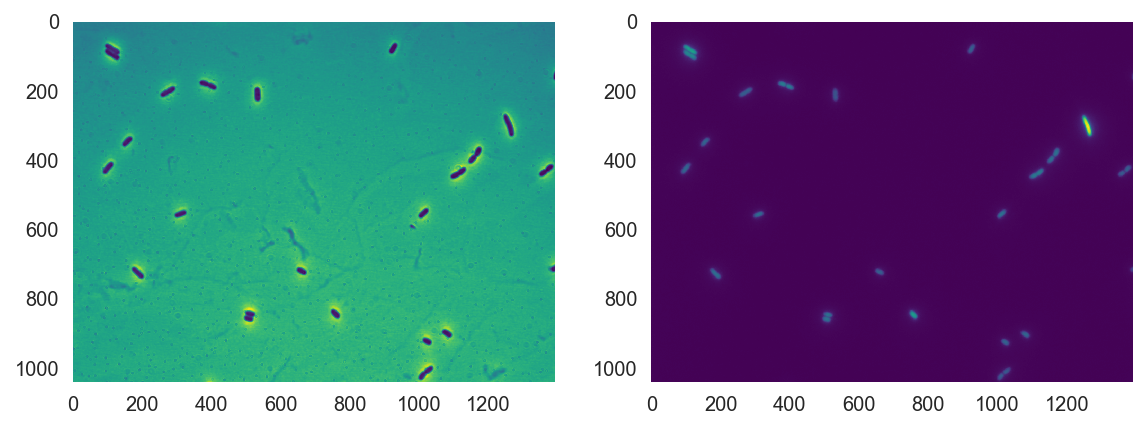

In [3]:
# Structuring element
selem = skimage.morphology.square(3)

# Perform median filter
im_phase_filt = skimage.filters.median(im_phase, selem)
im_fl_filt = skimage.filters.median(im_fl, selem)

# Show the images again
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase_filt, cmap=plt.cm.viridis)
    ax[1].imshow(im_fl_filt, cmap=plt.cm.viridis)

So, we will proceed to segment in phase and then use the fluorescence data to quantify expression levels. Before we begin our thresholding, however, we should correct our illumination issues in the phase contrast image which are likely caused by improper Köhler illumination.

## Background Subtraction

 We can correct for this non-uniform illumination by performing a **Gaussian background subtraction**. It is important for us to notice that the uneven illumination spans across a distance much greater than that of a single bacterium. In a Gaussian background subtraction, small variations in pixel value across the image are blurred using a two-dimensional Gaussian function leaving only large-scale variations in intensity. To correct for the non-uniformity of the illumination, we can simply subtract our Gaussian blurred image from our original.

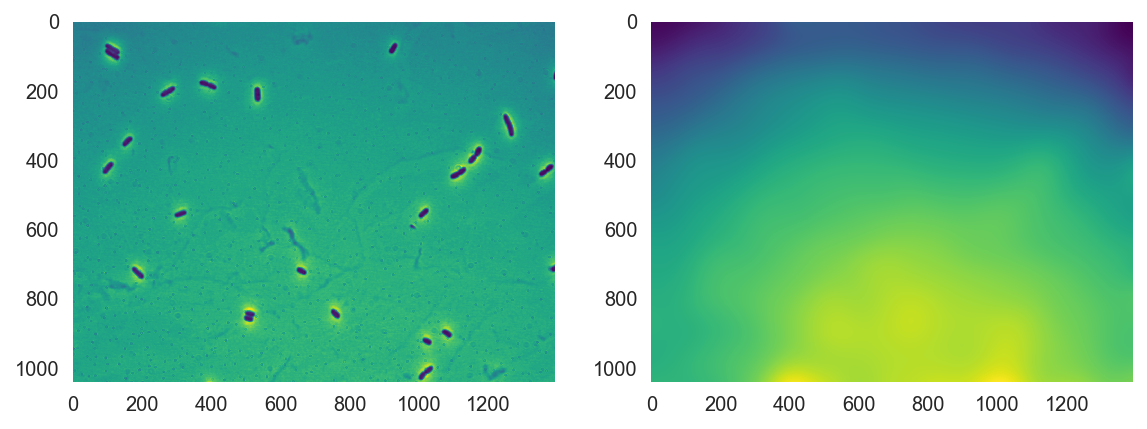

In [4]:
# Apply a gaussian blur with a 50 pixel radius. 
im_phase_gauss = skimage.filters.gaussian(im_phase_filt, 50.0)

# Show the two images side-by-side
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1,2, figsize=(9.5,8))
    ax[0].imshow(im_phase_filt, cmap=plt.cm.viridis)
    ax[1].imshow(im_phase_gauss, cmap=plt.cm.viridis)

While our input image has a `uint16` data type, our Gaussian filtered image is actually a `float64`. This means in order to have any substantive effect, our original image must also be converted to a `float64` before subtraction. We can use the `skimage.img_as_float()` function to perform this conversion. 

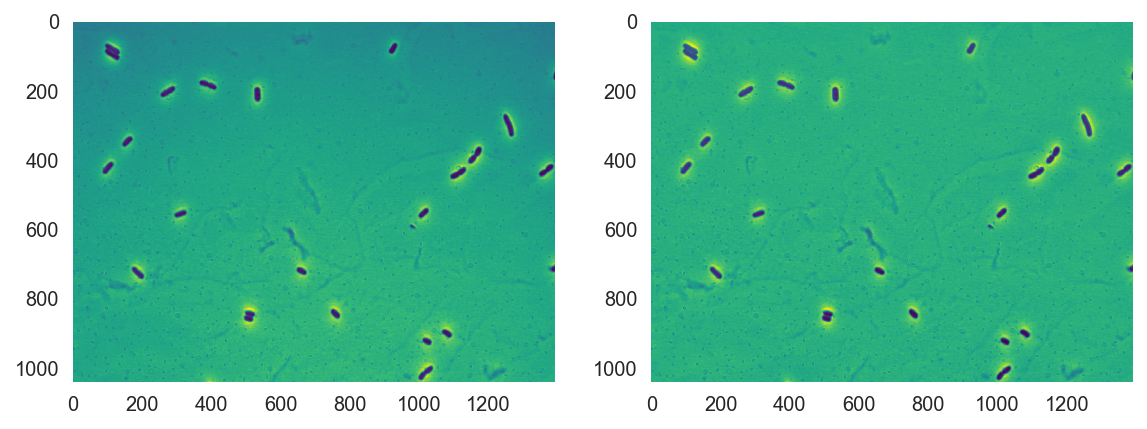

In [5]:
# Convert the median-filtered phase image to a float64
im_phase_float = skimage.img_as_float(im_phase_filt)

# Subtract our gaussian blurred image from the original.
im_phase_sub = im_phase_float - im_phase_gauss

# Show our original image and background subtracted image side-by-side.
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_phase_sub, cmap=plt.cm.viridis)

Voila! The pixel values appear much more uniform across the background of the image, meaning our segmentation safari can begin. 

## Segmenting the bacteria

As we go about doing the segmentation, it will be instructive to zoom in on a region of the image with some interesting features.  We define the indices of the subimage for use going forward. The `np.s_` trick of NumPy is a useful way to do this. It makes a tuple that you can use to easily slice NumPy arrays (remember, images are represented as NumPy arrays when you load them).

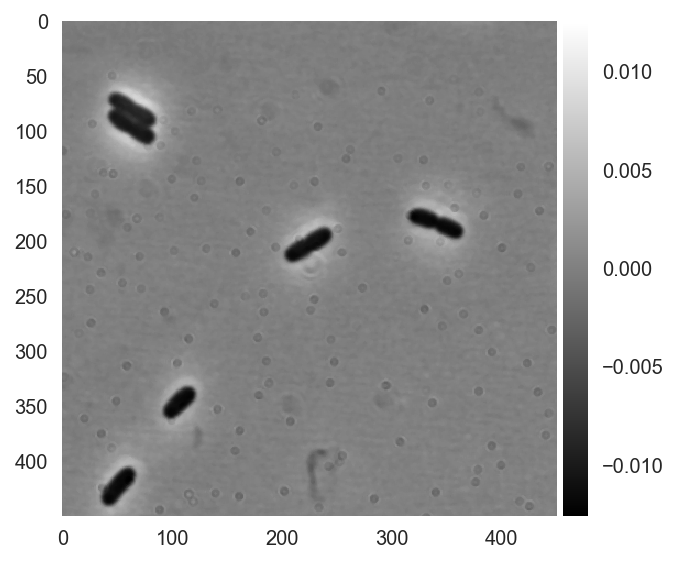

In [6]:
# Indices of subimage
slc = np.s_[0:450, 50:500]

# Look at subimage
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase_sub[slc], cmap=plt.cm.gray)

The image is littered with small dots.  These are the result of condensation of water vapor on the glass in front of the CCD of the camera.  This is a difficult issue in the particular lab space where this image was taken; there are issues with the air conditioning.  (Yes, that's right, the *air conditioning* can affect your data!)

### Denoising the image

As we prepare for segmentation, we should begin by denoising the image.  We already did a median filter to get rid of occasional bad pixels.

We may also want to get rid of all the dots on the camera glass.  These are the little circles in the image.  We can use a **total variation filter** for this purpose.  These filters compute local derivatives in the image and try to limit them.  The result is flatter, sometimes "cartoon-like" images.  We will not use this going forward, but only show it here for illustrative purposes.

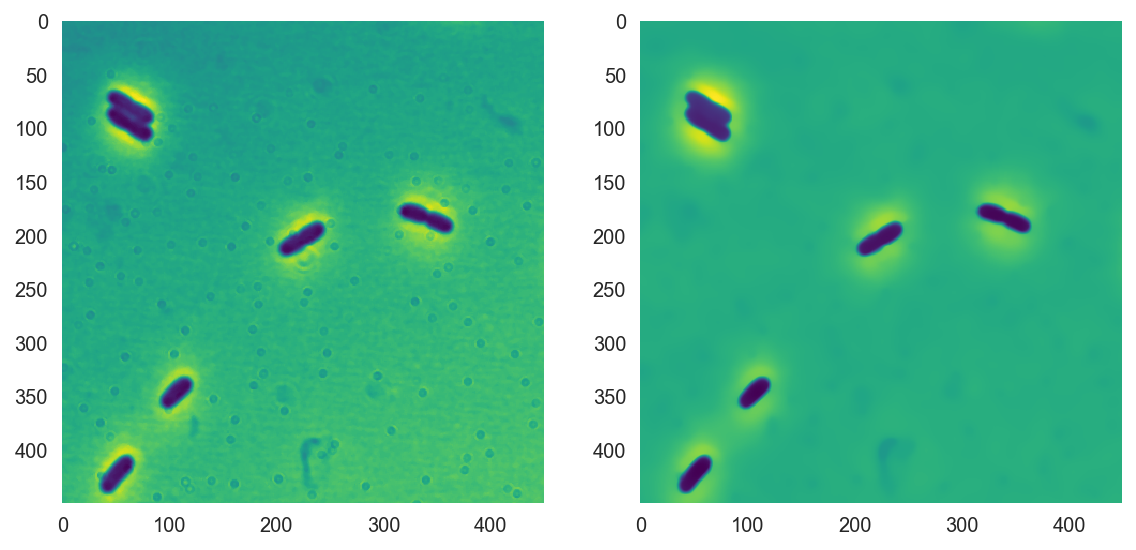

In [7]:
# Perform a Chambolle total variation filter.
im_phase_tv = skimage.restoration.denoise_tv_chambolle(
                                            im_phase_sub, weight=0.005)

# Look at result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase_filt[slc], cmap=plt.cm.viridis)
    ax[1].imshow(im_phase_tv[slc], cmap=plt.cm.viridis)

Going forward, we will use the median filtered image.

### Segmenting the bacteria with good ol' thresholding

Assuming we have taken care of any illumination issues that would preclude us from using a global thresholding method, we will go ahead and use a global threshold on the phase images to separate bacteria from background.  Note that this is one of many ways of segmenting the bacteria, and many more sophisticated and powerful methods are possible.

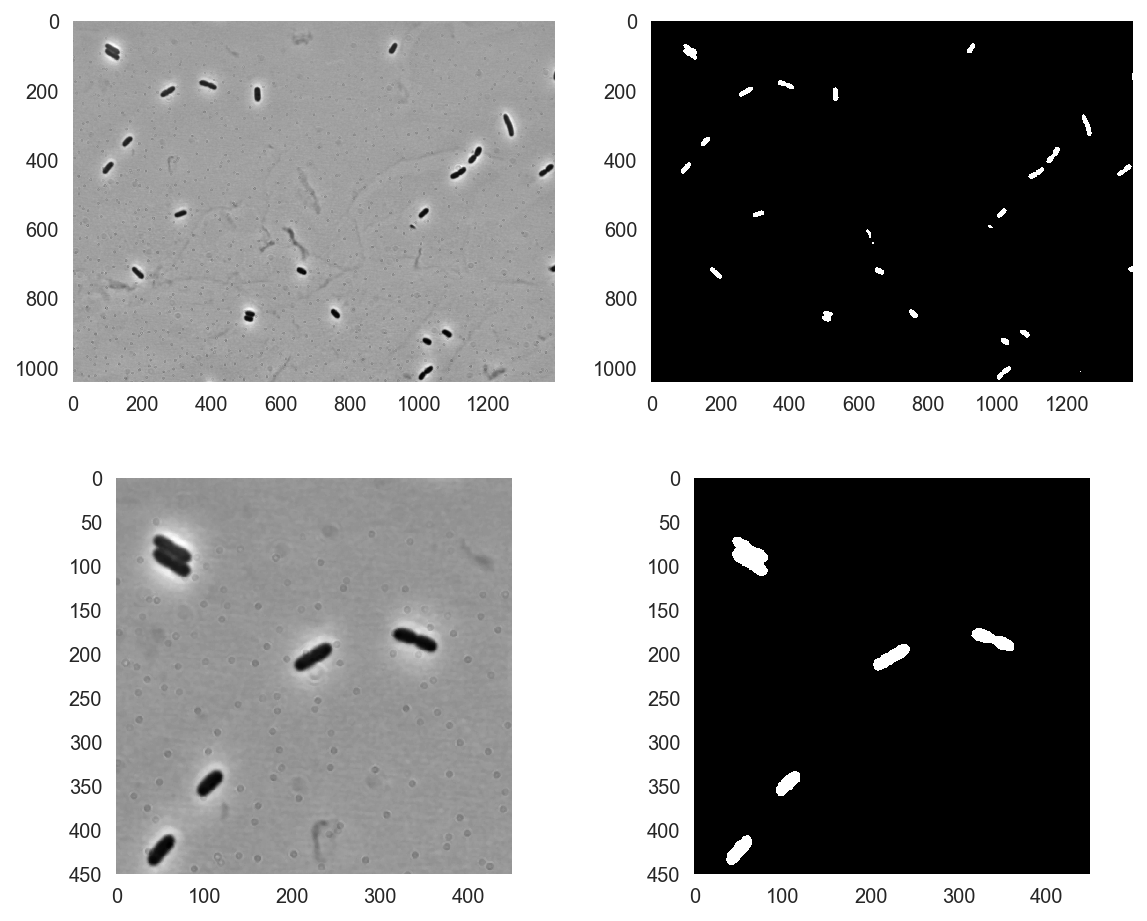

In [8]:
# Compute Otsu threshold value for median filtered image
thresh_otsu = skimage.filters.threshold_otsu(im_phase_sub)

# Construct thresholded image
im_bw = im_phase_sub < thresh_otsu

# Display images
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9.5, 8))
    ax[0,0].imshow(im_phase_sub, cmap=plt.cm.gray)
    ax[0,1].imshow(im_bw, cmap=plt.cm.gray)
    ax[1,0].imshow(im_phase_sub[slc], cmap=plt.cm.gray)
    ax[1,1].imshow(im_bw[slc], cmap=plt.cm.gray)

We see that we have some tiny particles that are not considered background.  We will deal with those explicitly in a moment.  Otherwise, we have effectively separated bacteria from background.

Since we will be quantifying fluorescent intensity in individual bacteria, we want to make sure only whole bacteria are considered.  Therefore, we should clear off any bacteria that are touching the border of the image.  There is a very convenient way to do this. The `skimage.segmentation.clear_border()` function takes a binary (black and white image) and clear out any white "island" that touches a border of the image.

In [11]:
# Clear border with 5 pixel buffer
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

## Quantifying the segmented regions

We have many white regions in the image, but only some of them are bacteria.  We would like to be able to identify what is bacteria and what is noise.  To this end, we need to compute the number of pixels in each white "island" in the thresholded image.  We can use the `skimage.measure.regionprops()` function to do this (and, as we will see, so much more!).  Before we can use it, we have to **label** the image.  That is, we need to assign a unique label to each white region in the thresholded region.

Number of individual regions =  24


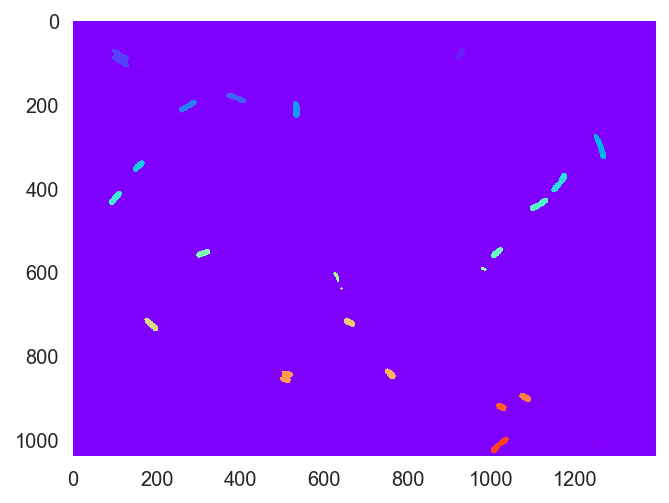

In [13]:
# Label binary image; background kwarg says value in im_bw to be background
im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)

# See result (one of the few times it's ok to use rainbow colormap!)
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of regions
print('Number of individual regions = ', n_labels)

We have 24 regions, but only 20 of these are bacteria, as we can see by hand counting.  We want to eliminate the small ones, so we will calculate the area of all of the regions. Note that this is a very clean image and we still ended up picking small bits of stuff in the background. `skimage.measure.regionprops()` computes the area of each region, in addition to lots of other useful statistics.  Conveniently, through the `intensity_image` keyword argument, we can specify a corresponding intensity image, in this case the fluorescent image.  `skimage.measure.regionprops()`. When an intensity image is specified, `skimage.measure.regionprops()` then also, among other things, average intensity for each of the regions.  Ultimately, we want the integrated intensity, which is just the average intensity times the area.

In [14]:
# Extract region props
im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_fl_filt)

That's it!  That's pretty much all there is to it!  We now need to eliminate regions that are too small to be bacteria.  First, let's get an estimate for how big a bacterium is.  We'll look again at our zoomed image.

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


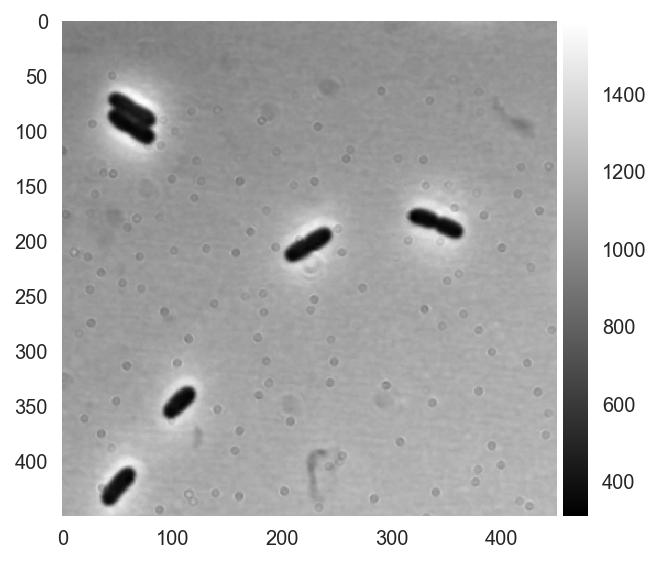

In [15]:
# Show zoomed in image
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase_filt[slc], cmap=plt.cm.gray)

Based on the image, I would estimate the bacteria are about 30 pixels long and 10 pixels wide, which is a bit of an underestimate.  So, let's say the cutoff for being a bacterium is about half that, or 150 pixels.  We can use all of the data conveniently stored in `im_props` to clear up our image.

Number of individual regions =  20


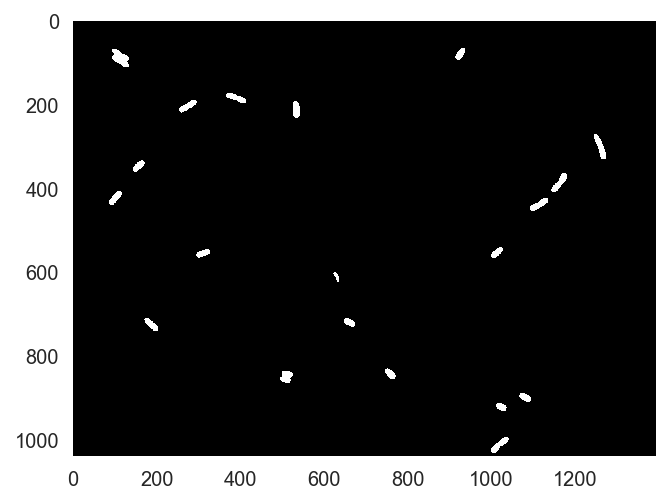

In [18]:
# Make a filtered black and white image
im_bw_filt = im_labeled > 0

# Define cutoff size
cutoff = 150

# Loop through image properties and delete small objects
n_regions = 0
for prop in im_props:
    if prop.area < cutoff:
        im_bw_filt[im_labeled==prop.label] = 0
    else:
        n_regions += 1
        
# Look at result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(im_bw_filt, cmap=plt.cm.gray)

# Show number of regions
print('Number of individual regions = ', n_regions)

So, considering only the larger features in the image, we have found the bacteria.

Now, there is still the issue of regions that contain two bacteria.  Again, we look at our zoomed in region.

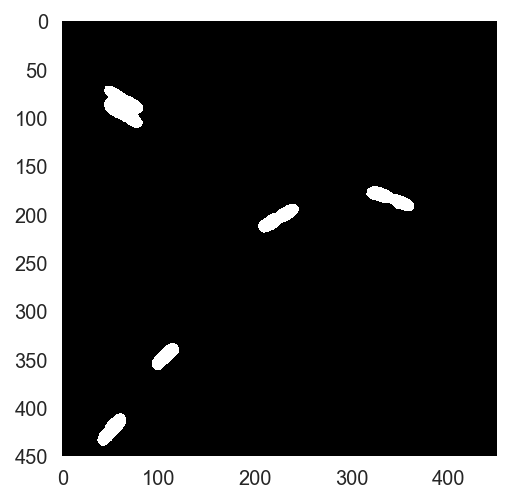

In [19]:
# Show zoomed in image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(im_bw_filt[slc], cmap=plt.cm.gray)

The bacteria in the upper left appear to be two different bacteria that may or may not be sisters.  However, the region at approximately `200,400` is either a bacterium that is dividing, or has just divided.  Depending on your experiment, you may want to treat these as a single bacterium or two. For this lesson, we will try to eliminate cells that are side-by-side and only keep the "lonely" cells. 

So, we can test for bacteria that are side-by-side, versus those that are in line with each other, as would be the case for a dividing bacterium.  We can use the eccentricity measure of the region.  According to the [skimage documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops),

>Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the distance between its minor and major axis length. The value is between 0 and 1.

So, we only want objects with large eccentricity, say above 0.85.

Number of individual regions =  15


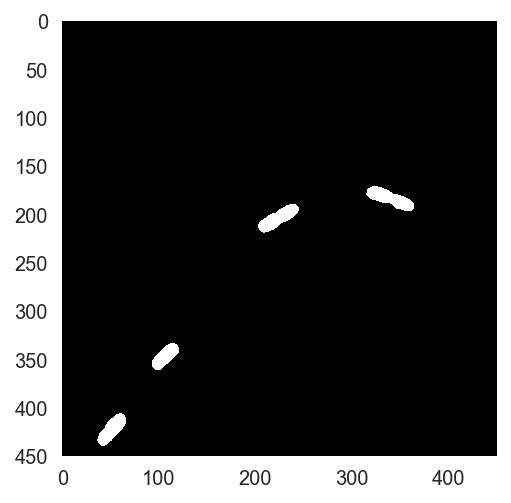

In [22]:
# Loop through image properties and delete small objects and round objects
n_regions = 0
for prop in im_props:
    if prop.area < cutoff or prop.eccentricity < 0.85:
        im_bw_filt[im_labeled==prop.label] = 0
    else:
        n_regions += 1
        
# Look at result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(im_bw_filt[slc], cmap=plt.cm.gray)

# Show number of regions
print('Number of individual regions = ', n_regions)

Voila!  Now, we can go ahead and compute the summed intensity of all regions we are interested in.

In [23]:
# Initialize list of intensities of individual bacteria
int_intensity = []

# Loop through regions and compute integrated intensity of bacteria
for prop in im_props:
    if prop.area > cutoff and prop.eccentricity > 0.8:
        int_intensity.append(prop.area * prop.mean_intensity)

# Convert list to NumPy array
int_intensity = np.array(int_intensity)

# Take a look
int_intensity

array([  85167.,  328888.,  153205.,  125405.,  110640.,  367573.,
         94001.,  164550.,  113119.,  160980.,   97293.,   95855.,
         19334.,  118286.,   77723.,  118638.,   85448.,  128360.])

The integrated intensities differ by about a factor of two from the lowest to the highest.

### Overlay of fluorescent image

Finally, we can overlay our fluorescent image with the phase contrast image.  We will take the fluorescent color to be green, and ranging from zero to one.

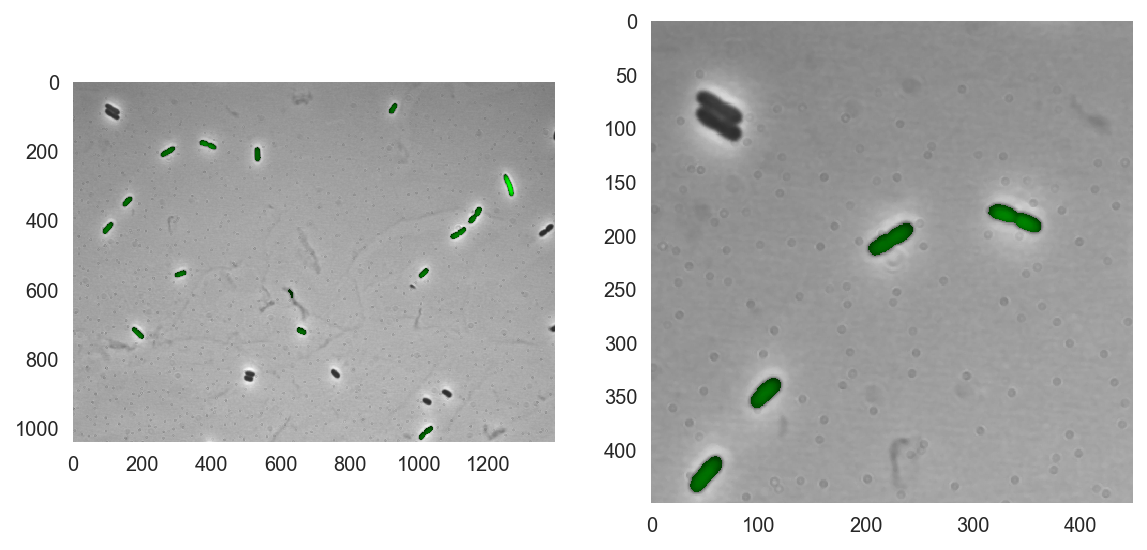

In [24]:
# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im_phase_filt / im_phase_filt.max()])

# Only show green channel on bacteria
im_rgb[im_bw_filt, 0] = 0
im_rgb[im_bw_filt, 1] = im_fl_filt[im_bw_filt] / im_fl_filt.max()
im_rgb[im_bw_filt, 2] = 0

# Show the result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_rgb)
    ax[1].imshow(im_rgb[slc][:]);

Beautiful!